<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/ShuffleNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install einops

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import os
import numpy as np
import pandas as pd
from einops import rearrange,reduce,repeat
from einops.layers.torch import EinMix as Mix
from einops.layers.torch import Rearrange,Reduce
import random

def set_seed(seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


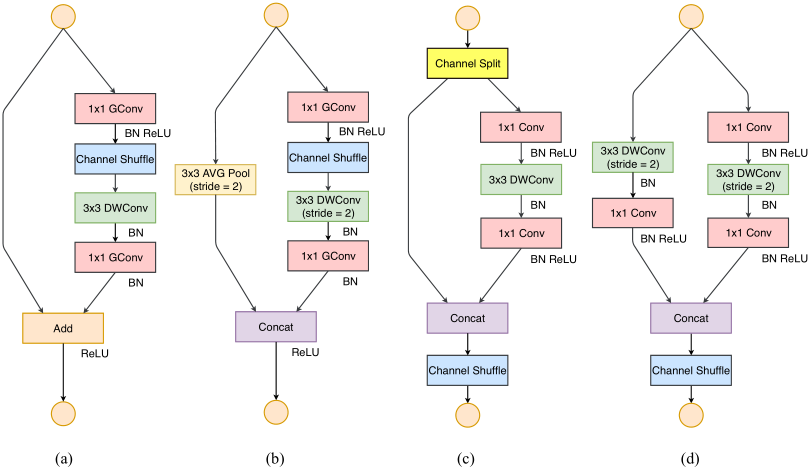

In [4]:
class ShuffleNetV2_Uint(nn.Module):
  def __init__(self,input_channel,output_channel,c_right_ratio = 0.5,Downsample = False,shuffle_groups=2):
    super(ShuffleNetV2_Uint,self).__init__()
    self.Downsample = Downsample

    c_right_out = int(output_channel * c_right_ratio)
    c_left_out = output_channel - c_right_out
    if self.Downsample ==True:
      c_left = c_right = input_channel
      self.Left = nn.Sequential(
          nn.Conv2d(c_left,c_left,(3,3),stride=2,padding=1,groups=c_left,bias=False),
          nn.BatchNorm2d(c_left),
          nn.Conv2d(c_left,c_left_out,(1,1),bias=False),
          nn.BatchNorm2d(c_left_out),
          nn.ReLU(inplace=True)
      )
      DwConv_Stride = 2
    else:
      c_right = int(input_channel * c_right_ratio)
      c_left = input_channel - c_right
      self.Left = Rearrange('...->...') #等价于identity
      DwConv_Stride = 1

    self.left_channel, self.right_channel = c_left, c_right
    '''
    #在论文中 提出的几个加快模型推理速度的准则中提到conv输入输出特征通道差别越小越好
    #因此 此处bottleneck_channel 与输入特征的通道数一样
    '''
    #bottleneck_channel = c_right //4
    bottleneck_channel = c_right 

    self.Right = nn.Sequential(
        nn.Conv2d(c_right,bottleneck_channel,(1,1),bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(bottleneck_channel,\
                  bottleneck_channel,(3,3),\
                  stride=DwConv_Stride,\
                  padding=1,\
                  groups = bottleneck_channel,\
                  bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        nn.Conv2d(bottleneck_channel,c_right_out,(1,1),bias=False),
        nn.BatchNorm2d(c_right_out),
        nn.ReLU(inplace=True),
    )
    self.channel_shuffle = Rearrange('b (c1 c2) h w -> b (c2 c1) h w',c1=shuffle_groups)
  def forward(self,x):
    if self.Downsample ==True:
      x_left,x_right = x,x
    else:
      x_left,x_right = torch.split(x,(self.left_channel,self.right_channel),dim=1)
    
    x = torch.concat([self.Left(x_left),self.Right(x_right)],dim=1)
    x = self.channel_shuffle(x)
    return x

In [5]:
x = torch.randn(3,116,224,224)
model = ShuffleNetV2_Uint(116,116,Downsample=False)
model(x).shape

torch.Size([3, 116, 224, 224])

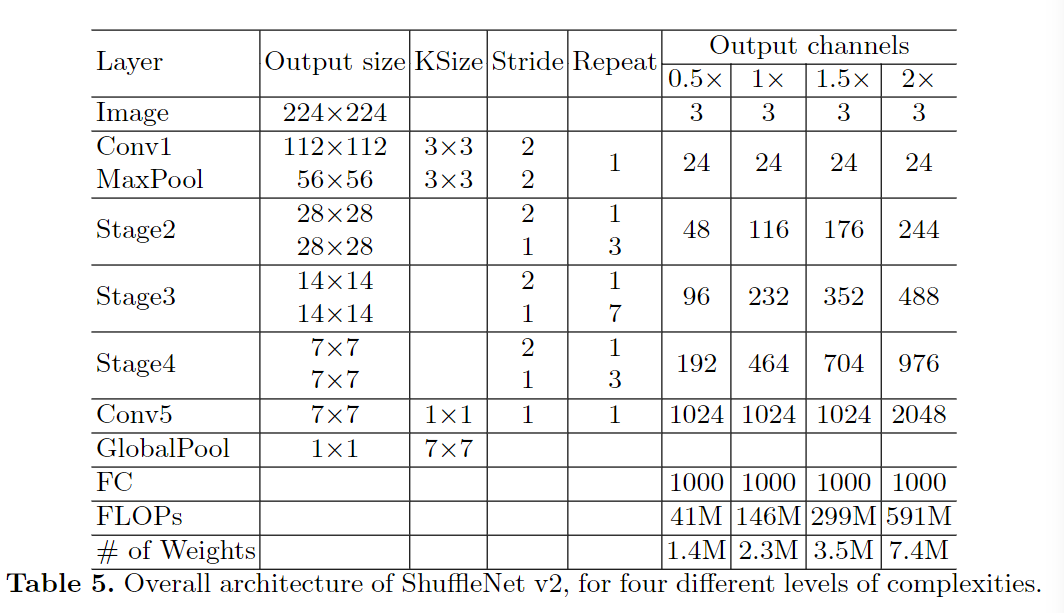

In [24]:
output_channel_list = [24,116,232,464,1024]
class shuffleNetV2(nn.Module):
  def __init__(self,num_class,input_channel,output_channel_list):
    super(shuffleNetV2,self).__init__()
    self.Conv1_MaxPool = nn.Sequential(
        nn.Conv2d(input_channel,output_channel_list[0],(3,3),stride=2,padding=1,bias=False),
        nn.BatchNorm2d(output_channel_list[0]),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((3,3),stride=2,padding=1),
    )
    self.Stage2 = nn.Sequential(
        ShuffleNetV2_Uint(output_channel_list[0],output_channel_list[1],Downsample=True),
        *[ShuffleNetV2_Uint(output_channel_list[1],output_channel_list[1]) for i in range(3)]
    )
    self.Stage3 = nn.Sequential(
        ShuffleNetV2_Uint(output_channel_list[1],output_channel_list[2],Downsample=True),
        *[ShuffleNetV2_Uint(output_channel_list[2],output_channel_list[2]) for i in range(7)]
    )
    self.Stage4 = nn.Sequential(
        ShuffleNetV2_Uint(output_channel_list[2],output_channel_list[3],Downsample=True),
        *[ShuffleNetV2_Uint(output_channel_list[3],output_channel_list[3]) for i in range(3)]
    )
    self.Fianl_layer = nn.Sequential(
        nn.Conv2d(output_channel_list[3],output_channel_list[4],(1,1),bias=False),
        nn.BatchNorm2d(output_channel_list[4]),
        nn.ReLU(inplace=True),
        Reduce('b c h w -> b c','mean'),
        nn.Linear(output_channel_list[-1],num_class)
    )
  def forward(self,x):
    x= self.Conv1_MaxPool(x)
    x= self.Stage2(x)
    x= self.Stage3(x)
    x= self.Stage4(x)
    x= self.Fianl_layer(x)
    return x

In [25]:
model = shuffleNetV2(1000,3,output_channel_list)
x= torch.randn(10,3,224,224)
model(x).shape

torch.Size([10, 1000])